# Demonstrate langgraph persistence to sqllite DB

In [1]:
from IPython.display import Image, display
from langchain_openai import ChatOpenAI
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import StateGraph
from typing import Annotated, Literal
from typing_extensions import TypedDict

## Define state that we are going to persist

In [2]:
class State(TypedDict):
    """State containing current count"""
    count: Annotated[int, 0]

## Define nodes and edges

In [3]:
def inc_count(state):
    """Increment the count"""
    state['count'] += 1
    return state

def ask_user(_):
    """Ask user node"""
    pass

## Define langgraph

In [4]:
graph = StateGraph(State)

### Define two nodes we will cycle between

In [5]:
graph.add_node("inc_count", inc_count)
graph.add_node("ask_user", ask_user)


### Set entry point to be inc_count

In [6]:
graph.set_entry_point("inc_count")

### Add edges

In [7]:
graph.add_edge("inc_count", "ask_user")
graph.add_edge("ask_user", "inc_count")

## Use sqlite database for persistence

In [8]:
CONN_STRING="/Users/sameerm/AI-Agents/testDB.db"
db = SqliteSaver.from_conn_string(CONN_STRING)

## Use memory for persistence

In [9]:
memory = SqliteSaver.from_conn_string(":memory:")

## Compile the graph passing the checkpointer for persistence

In [10]:
app_db = graph.compile(checkpointer=db, interrupt_before=["ask_user"])
app_memory = graph.compile(checkpointer=memory, interrupt_before=["ask_user"])

## Display the graph

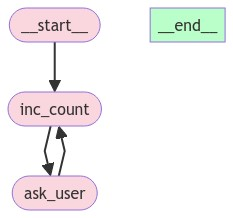

In [11]:
try:
    display(Image(app_db.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

## Interct with the graphs

In [12]:
config = {"configurable": {"thread_id": "2"}}
for count in app_db.stream({"count": 0}, config, stream_mode="values"):
    print (count)

{'count': 0}
{'count': 1}


In [13]:
config = {"configurable": {"thread_id": "3"}}
for count in app_memory.stream({"count": 0}, config, stream_mode="values"):
    print (count)

{'count': 0}
{'count': 1}


In [12]:
config = {"configurable": {"thread_id": "2"}}
for count in app_db.stream(None, config, stream_mode="values"):
    print (count)

{'count': 3}


In [13]:
config = {"configurable": {"thread_id": "3"}}
for count in app_memory.stream(None, config, stream_mode="values"):
    print (count)

ValueError: No tasks to run in graph.